In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from pathlib import Path
from tqdm import tqdm_notebook, tqdm, trange
import numpy as np
import pandas as pd
import itertools
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Lambda, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from DataPrep import preprocess_image, augment_pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('datasets/train.csv')
df

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
...,...,...
9845,ffe5c306.jpg,w_2ceab05
9846,ffeaa7a4.jpg,w_b067417
9847,ffecec63.jpg,w_8b56cb1
9848,fff04277.jpg,w_2dcbf82


In [3]:
top_counts = df['Id'].value_counts()[:9]
top_counts.drop(index='new_whale', inplace=True)
top_counts

w_1287fbc    34
w_98baff9    27
w_7554f44    26
w_1eafe46    23
w_693c9ee    22
w_fd1cb9d    22
w_ab4cae2    22
w_73d5489    21
Name: Id, dtype: int64

In [4]:
top_df = df[df['Id'].isin(top_counts.index)]
top_df

,Image,Id
1,000466c4.jpg,w_1287fbc
13,00467ae9.jpg,w_fd1cb9d
104,02916b71.jpg,w_73d5489
183,0496e682.jpg,w_fd1cb9d
253,0603a403.jpg,w_1287fbc
...,...,...
9379,f4063698.jpg,w_7554f44
9446,f5ac7c84.jpg,w_1287fbc
9464,f61f4cb3.jpg,w_ab4cae2
9518,f767cdfa.jpg,w_1eafe46


In [15]:
def create_feature_extractor():
    backbone = DenseNet121(include_top=False,
                           weights='imagenet',
                           input_shape=(478, 968, 3)
                          )
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Activation('sigmoid')
    ])
    return model
feature_extractor = create_feature_extractor()

In [ ]:
df = top_df.copy()
input_dir = Path('datasets/train/train')
imgs = [cv2.imread(str(input_dir / img_name)) for img_name in df['Image']]
imgs = [preprocess_image(img) for img in imgs]
imgs = np.array(imgs)

In [17]:
features = feature_extractor.predict(imgs, verbose=1)

7/7 [==============================] - 2s 249ms/step


In [38]:
pca = PCA(n_components=2)
pca.fit(features)
pca.explained_variance_

array([0.3537001 , 0.13399796], dtype=float32)

In [50]:
df['feature'] = list(pca.transform(features))
df

,Image,Id,feature
1,000466c4.jpg,w_1287fbc,"[-0.2887354, 0.791273]"
13,00467ae9.jpg,w_fd1cb9d,"[-0.17396402, -0.17378594]"
104,02916b71.jpg,w_73d5489,"[-0.4837259, -0.25984627]"
183,0496e682.jpg,w_fd1cb9d,"[0.64624405, -0.12780045]"
253,0603a403.jpg,w_1287fbc,"[-0.22597128, -0.11888787]"
...,...,...,...
9379,f4063698.jpg,w_7554f44,"[-0.58546984, 0.53707325]"
9446,f5ac7c84.jpg,w_1287fbc,"[1.1454511, 0.39503962]"
9464,f61f4cb3.jpg,w_ab4cae2,"[-0.7552139, -0.23334897]"
9518,f767cdfa.jpg,w_1eafe46,"[-0.23729677, -0.28313047]"


In [51]:
features = np.concatenate(df['feature'].to_numpy()).reshape((-1, 2))

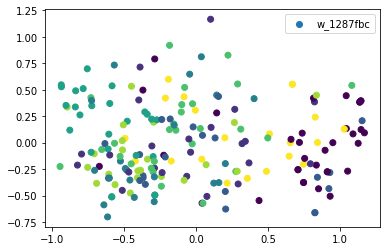

In [77]:
id_encoder = LabelEncoder()
_label = id_encoder.fit_transform(df['Id'])
# del label

plt.scatter(features[:, 0], features[:, 1], c=_label)
plt.legend(id_encoder.classes_.tolist())
plt.show()

In [3]:

class DataGenerator:
    
    def __init__(self, df, input_dir):
        self.input_dir = input_dir
        self.total_ids = set(df['Id'].drop_duplicates())
        self.df = df.set_index('Id')
    
    def create_generator(self, batch_size, positive_ratio=0.5, augment=False):
        while True:
            batch_df = self.df.sample(batch_size)

            lefts = []
            rights = []
            ys = []
            for Id1, whale1 in batch_df.iterrows():
                if np.random.rand() < positive_ratio:
                    candidate_df = self.df.loc[Id1]
                    y = 1
                else:
                    candidate_df = self.df.loc[self.total_ids - {Id1}]
                    y = 0

                if len(candidate_df) > 1:
                    whale2 = candidate_df.sample(1).iloc[0]
                else:
                    whale2 = candidate_df

                img1 = cv2.imread(str(self.input_dir / whale1['Image']))
                img2 = cv2.imread(str(self.input_dir / whale2['Image']))
                
                if augment:
                    img1, img2 = augment_pipeline.augment(images=[img1, img2])
                    
                img1 = preprocess_image(img1)
                img2 = preprocess_image(img2)

                lefts.append(img1)
                rights.append(img2)
                ys.append(y)

            lefts = np.array(lefts)
            rights = np.array(rights)
            ys = np.array(ys)
            
            yield [lefts, rights], ys
            


In [16]:
input_shape = (478, 968, 3)
feature_extractor.trainable = False

left_input = Input(input_shape)
right_input = Input(input_shape)
left_features = feature_extractor(left_input)
right_features = feature_extractor(right_input)

distance_layer = Lambda(lambda f: K.abs(f[0] - f[1]))
distance = distance_layer([left_features, right_features])

similarity = Dense(1, activation='sigmoid')(distance)

model = Model(inputs=[left_input, right_input], outputs=similarity)

In [17]:
optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [18]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 478, 968, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 478, 968, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         7037504     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1024)         0           sequential_1[1][0]         

In [ ]:
batch_size = 16
df = pd.read_csv('datasets/train.csv')
input_dir = Path('datasets/train/train')
datagen = DataGenerator(df, input_dir)
gen = datagen.create_generator(batch_size=batch_size, positive_ratio=0.5)

model_dir = Path('benchmark/siamese-densenet')
model_dir.mkdir(exist_ok=True)
model.fit(gen,
          initial_epoch=9,
          epochs=50,
          steps_per_epoch=len(df) // (2*batch_size),
          callbacks=[
              TensorBoard(str(model_dir)),
              ModelCheckpoint(str(model_dir / 'freeze-ep-{epoch:02d}-acc{acc:.4f}.hdf5'),
                        monitor='acc',
                        verbose=1,
                        save_best_only=True,
                        mode='max')
          ]
)

Epoch 10/50
235/307 [=====================>........] - ETA: 36s - loss: 0.4941 - acc: 0.7721